In [1]:
'''Imports'''
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from utils import encode
import seaborn as sns

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, f1_score


In [2]:
'''Configure Utilities'''
np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
'''Load Data'''
common_crs = "EPSG:4269"
coastline_shp = './geoData/califorina_pacific_coast-shapefile/3853-s3_2002_s3_reg_pacific_ocean.shp'
places_shp = './geoData/ca_places/CA_Places.shp'
counties_shp = './geoData/us_county/tl_2023_us_county.shp'
# counties_shp = './geoData/ca_counties/CA_Counties.shp'


coastline = gpd.read_file(coastline_shp)
places = gpd.read_file(places_shp)
counties = gpd.read_file(counties_shp)

rawData = fetch_california_housing(as_frame=True)
cal_housing_geo = gpd.GeoDataFrame(rawData.data, geometry=gpd.points_from_xy(rawData.data.Longitude, rawData.data.Latitude), crs=common_crs)
cal_housing_geo['y'] = rawData.target

KeyError: 194

In [ ]:
'''Standardize Cordinate Projection'''
coastline = coastline.to_crs(common_crs)
places = places.to_crs(common_crs)
counties = counties.to_crs(common_crs)

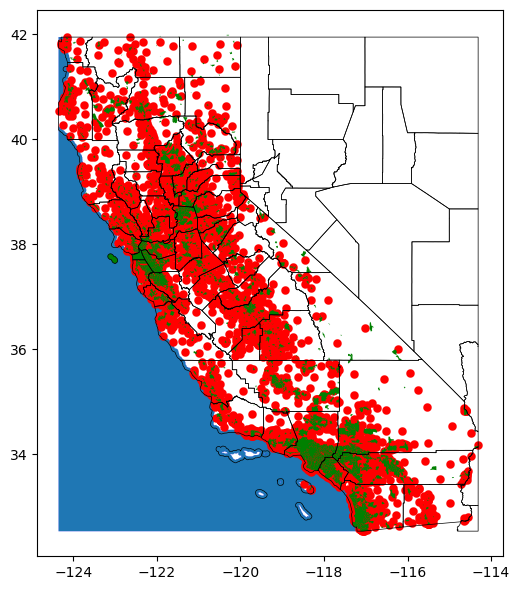

In [ ]:
'''Set geo bounding box and plot'''
# print(cal_housing_geo.total_bounds)
housing_bounds = cal_housing_geo.total_bounds
counties = counties.clip(housing_bounds)
coastline = coastline.clip(housing_bounds)
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)

coastline.plot(ax=ax, edgecolor='blue', linewidth=0.1)
counties.boundary.plot(ax=ax, edgecolor='black', linewidth=.5)
cal_housing_geo.plot(ax=ax, color='red', linewidth=0.1)
places.plot(ax=ax, color='green', linewidth=1.0)
plt.show()



In [ ]:
'''Feature Engineer Distance from Coast'''
house_to_coast = gpd.sjoin_nearest(cal_housing_geo, coastline, how="left", distance_col="meters")
cal_housing_geo['m_to_coast'] = house_to_coast['meters']

/Users/watsonblair/anaconda3/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
'''Feature Engineer Distance from Census Designated Place'''
house_to_interest = gpd.sjoin_nearest(cal_housing_geo, places, how="left", distance_col="meters")
# cal_housing_geo['CDP'] = house_to_interest['NAME'] // The name of the CDP does not appear to impact model performance
cal_housing_geo['m_to_CDP'] = house_to_interest['meters']

/Users/watsonblair/anaconda3/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
'''Feature Engineer County Data'''
# This data point does not appear to impact model performance, but can be useful for EDA.
# house_to_county = gpd.sjoin_nearest(cal_housing_geo, counties, how="left")
# cal_housing_geo['county_name'] = house_to_county['NAME']

'Feature Engineer County Data'

In [ ]:
'''EDA: Color code counties by target value'''
edaData = gpd.GeoDataFrame(rawData.data, geometry=gpd.points_from_xy(rawData.data.Longitude, rawData.data.Latitude), crs=common_crs)
edaData['y'] = rawData.target

house_to_county = gpd.sjoin_nearest(edaData, counties, how="left")
edaData['county_name'] = house_to_county['NAME']


/Users/watsonblair/anaconda3/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
meanTarget = edaData.groupby('county_name')['y'].mean().reset_index()

print(meanTarget[meanTarget['county_name'] == 'Alameda']['y'][0])

2.085394595660749


In [ ]:
'''Add Mean Target value to county data'''
meanTarget = edaData.groupby('county_name')['y'].mean().reset_index()

def setMeanTarget(row):
    # print(meanTarget[meanTarget['county_name'] == row['NAME']]['y'])
    # value = meanTarget[meanTarget['county_name'] == row['NAME']]['y']
    # print(value.pop(0))
    # row['mean_target'] = value
    return row

withTarget = counties.apply(setMeanTarget, axis=1)

# print(withTarget.head())


In [ ]:
# cal_housing_geo = encode(cal_housing_geo, ['CDP','county_name'])

In [ ]:
# cal_housing_geo.head()

In [ ]:
modelData = cal_housing_geo.drop(columns=['y', 'geometry'])
X_train, X_test, y_train, y_test = train_test_split(modelData, rawData.target, test_size=0.3, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('regress',RandomForestRegressor())], verbose=True)
predicted = pipe.fit(X_train, y_train).predict(X_test)


KeyError: "['y'] not found in axis"

In [ ]:
mse = mean_squared_error(y_test, predicted)
print(mse)

0.2543506000616298


<Axes: title={'center': 'Feature Importances'}>

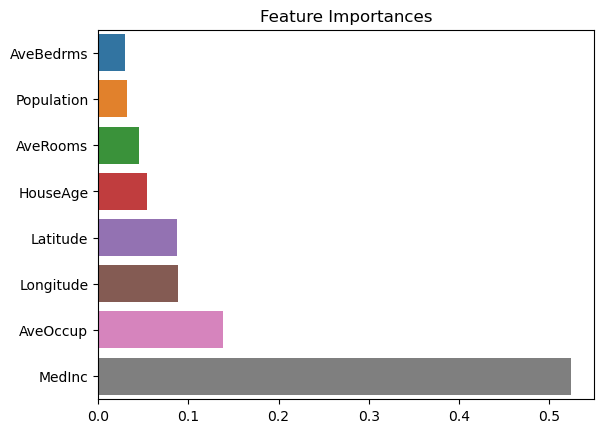

In [ ]:
regressor = pipe.steps[-1][-1]

feat_importance = list(zip(modelData.columns,regressor.feature_importances_))
feat_importance = sorted(feat_importance, key=lambda tup: tup[1])

feat=[x for x,y in feat_importance]
importance=[y for x,y in feat_importance]


plt.title('Feature Importances')
sns.barplot(y=feat, x=importance)

# print(*importance)